# Address completeness classification with traditional programming techniques
Data & AI course, UC Leuven, 2021 Fall
### Project supervisors
- Tom Magerman
- Aimée Lynn Backiel

### Project team (Group 4)
- Karolis Medekša
- Pedro Teixeira Palma Rosa
- Hysa Mello de Alcântara
- Josep Jacob Chetrit Valdepeñas

## Goals
The goal if the assignment to implement a Python program that is capable of determining whether a provided street address is complete (having a street name, house/apartment number, postal code, city) or incomplete (missing any of previously mentioned criteria).

# Implementation
The first step of solving the problem is reading the input file into an object of `pandas.DataFrame`. Function `read_DataFrame_from_file` is responsible for that. While doing the exercise it is also convenient to output the data table to excel for an easier inspection, `write_DataFrame_to_excel` is responsible for that, the function not only outputs the data frame to an excel file, but also adds additional formatting, for instance, coloring rows of complete addresses in green and those that are incomplete - in red.  

In [1]:
import pandas as pd

DATA_INPUT_FILENAME = 'input.txt'
DATA_OUTPUT_FILENAME = 'classified.xlsx'

def read_DataFrame_from_file():
    return pd.read_csv(DATA_INPUT_FILENAME, delimiter='\t')


def write_DataFrame_to_excel(df: pd.DataFrame):
    sheet_name = 'Classified'

    with pd.ExcelWriter(DATA_OUTPUT_FILENAME, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        worksheet = writer.sheets[sheet_name]
        # format all data as a table
        worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
            'columns': [{'header': col_name} for col_name in df.columns],
            'style': 'Table Style Medium 5'
        })
        # Widen the address column
        worksheet.set_column('C:C', 70)

        # Add formatting - red for negative, green - for positive qualification
        redFormat = writer.book.add_format({'bg_color': '#FF0000', 'font_color': '#000000'})
        greenFormat = writer.book.add_format({'bg_color': '#00B050', 'font_color': '#000000'})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=0',
                                          'format': redFormat})
        worksheet.conditional_format(0, 0, df.shape[0], df.shape[1]-1, {'type': 'formula',
                                          'criteria': '=$E1=1',
                                          'format': greenFormat})

With the simplest possible strategy of classification (label all addresses as incomplete) we can verify that input/output behavior is working correctly

In [4]:
def classify_address(dataFrame: pd.DataFrame):
    dataFrame['complete'] = 0
    return dataFrame


def init():
    classified = classify_address(read_DataFrame_from_file())
    write_DataFrame_to_excel(classified)


init()

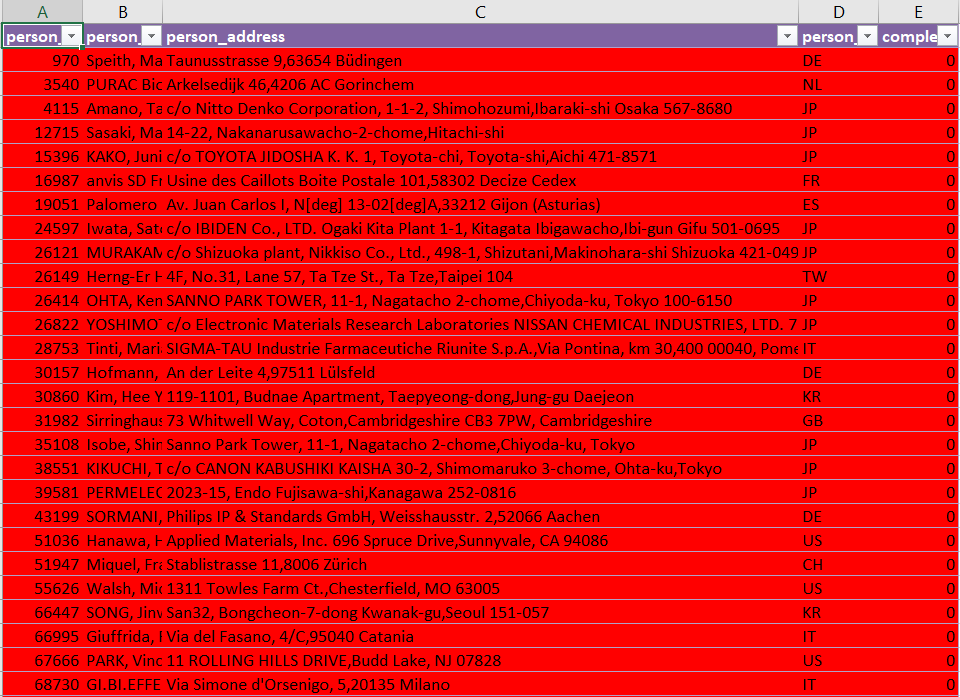

# Determining the postal code

TODO: Countries without any postal code: AN, BB, BD, BO, BS, CL, CR, CS, DO, EG, HK, IE, IR, KW, LK, PK, RS, SV, TN, UA, UG, VE, VN.
What to do with Taiwan and Japan? It's zip codes are only three numbers, the same as many house numbers

--------------
Postal code is one of the things which can be determined via regex, mainly because postal codes usually follow the same structure. However, the problem arises because different countries have varying postal code formats, moreover, in some addresses postal codes are international, in others - local.
Nevertheless, we can come up with checks that should account for the vast majority of cases - in most European countries postal codes are composed of a combination of one to three letters and number sequences. In other places, for instance Canada, we can find postal codes composed of six or more alphanumerical symbols. We can have a single regular expression, composed of more than one check, to capture all these cases (see the image below)

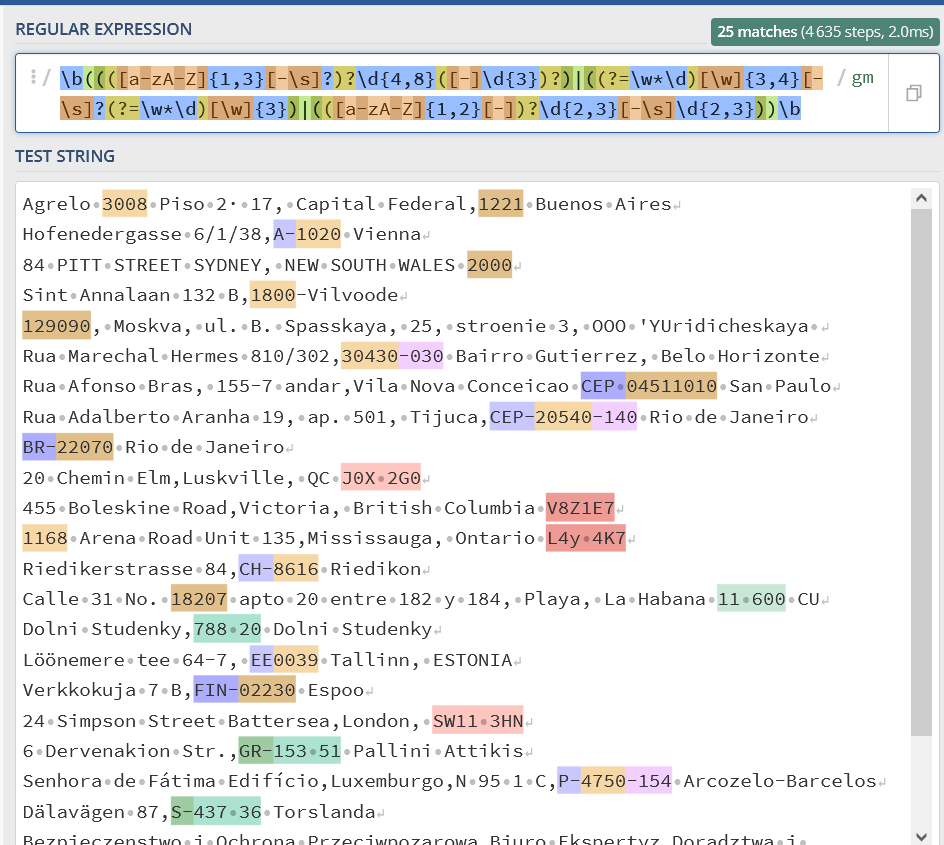

We can now implement a `reGex` check to test whether an address is complete or incomplete.

In [8]:
import re

POSTAL_CODE_REGEX = r'\b((([a-zA-Z]{1,3}[-\s]?)?\d{4,8}([-]\d{3})?)|((?=\w*\d)[\w]{3,4}[-\s]?(?=\w*\d)[\w]{3})|(([a-zA-Z]{1,2}[-])?\d{2,3}[-\s]\d{2,3}))\b'

def does_contain_valid_postal_code(input):
    match = re.search(POSTAL_CODE_REGEX, input)
    if (match is not None):
        return True
    return False


def is_valid_address(input):
    return does_contain_valid_postal_code(input)


def classify_address(dataFrame: pd.DataFrame):
    dataFrame['complete'] = dataFrame.apply(lambda row: 1 if is_valid_address(row['person_address']) else 0, axis=1)

    return dataFrame

df = pd.DataFrame({
    'person_address': [
        '206 rue St-Jacques,Longueuil, Québec J4W 3B9',
        'Ukmerges 17-27,LT-49317 Kaunas',
        'Larchmont,NY'
    ]
})
print(classify_address(df))

                                 person_address  complete
0  206 rue St-Jacques,Longueuil, Québec J4W 3B9         1
1                Ukmerges 17-27,LT-49317 Kaunas         1
2                                  Larchmont,NY         0
